In [1]:
import pandas as pd
import numpy as np
import konlpy

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import re

%matplotlib inline

# 한글폰트 지정
plt.rc("font", family = "Malgun Gothic")
plt.rc("axes", unicode_minus = False)

# 스타일 지정
plt.style.use(['ggplot'])

In [17]:
data = pd.read_csv('everytime_review_pre.csv')
data.columns

Index(['category', 'lecture', 'professor', 'review', 'stars', 'semester',
       'length'],
      dtype='object')

# wordcloud

In [4]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from os import path
# 한글 폰트 경로 지정 필요
FONT_PATH = 'C:/windows/Fonts/a드림고딕4.ttf'



In [15]:
# 불용어 지정 : from_frequencies는 이를 사용하지는 않음
from wordcloud import STOPWORDS

stopwords = {'강의', '교수님', '교수', '수업','내용', '강의', '시험', '과제', '학점', '해주시', '때문', '하루', '이번', '만큼','자체',
            '학생','학기','연대','평소','이번','제가','본인','사람','시간', '문제', '윤소연', '정도', '현정', '얘기', '느낌', '니다', 
             '경우', '나름', '고리', '부분', '때문','라고', '진짜', '동안', '대로', '와서'}




In [13]:
# 평점 4, 5 점 강의평만 워드클라우드
def review_cloud_pos(lecture):
    df = data[(data['lecture'] == lecture)&(data['stars'].isin([4,5]))]
    contents = list(df['review'])
    contents = ' '.join(contents)


    # 형태소 분석기
    komoran = konlpy.tag.Komoran(userdic='사용자사전.txt')
    komoran_nouns = komoran.nouns(contents)
    words_list = [w for w in komoran_nouns if len(w) != 1]

    # 실질 형태소 필터링 및 불용어 제거
    dic_c = Counter(words_list)
    for k in list(dic_c.keys()):
        if dic_c[k] < 6:
            del dic_c[k]
        elif k in stopwords:
            del dic_c[k]
        else:
            continue
    #word_list = list(dic_c.keys())


    wordcloud = WordCloud(max_font_size=75, relative_scaling=.8, font_path=FONT_PATH, 
                          background_color='white', stopwords = stopwords, max_words = 180, colormap = "Blues")
    wordcloud = wordcloud.generate_from_frequencies(dic_c)

    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
    
# 평점 1,2 점 강의만 워드클라우드
def review_cloud_neg(lecture):
    df = data[(data['lecture'] == lecture)&(data['stars'].isin([1,2]))]
    contents = list(df['review'])
    contents = ' '.join(contents)


    # 형태소 분석기
    komoran = konlpy.tag.Komoran(userdic='사용자사전.txt')
    komoran_nouns = komoran.nouns(contents)
    words_list = [w for w in komoran_nouns if len(w) != 1]

    # 실질 형태소 필터링 및 불용어 제거
    dic_c = Counter(words_list)
    for k in list(dic_c.keys()):
        if dic_c[k] < 2:
            del dic_c[k]
        elif k in stopwords:
            del dic_c[k]
        else:
            continue
    #word_list = list(dic_c.keys())


    wordcloud = WordCloud(max_font_size=75, relative_scaling=.8, font_path=FONT_PATH, 
                          background_color='white', stopwords = stopwords, max_words = 180, colormap = 'flare')
    wordcloud = wordcloud.generate_from_frequencies(dic_c)

    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

    
# 전체 리뷰 클라우드
def review_cloud(lecture):
    df = data[data['lecture'] == lecture]
    contents = list(df['review'])
    contents = ' '.join(contents)


    # 형태소 분석기
    komoran = konlpy.tag.Komoran(userdic='사용자사전.txt')
    komoran_nouns = komoran.nouns(contents)
    words_list = [w for w in komoran_nouns if len(w) != 1]

    # 실질 형태소 필터링 및 불용어 제거
    dic_c = Counter(words_list)
    for k in list(dic_c.keys()):
        if dic_c[k] < 8:
            del dic_c[k]
        elif k in stopwords:
            del dic_c[k]
        else:
            continue
    #word_list = list(dic_c.keys())


    wordcloud = WordCloud(max_font_size=75, relative_scaling=.8, font_path=FONT_PATH, 
                          background_color='white', stopwords = stopwords, max_words = 200)
    #wordcloud.generate(noun_text) 
    #contents= ' '.join(list(dic_c.keys()))
    #wordcloud = wordcloud.generate_from_text(contents)
    wordcloud = wordcloud.generate_from_frequencies(dic_c)
    wordcloud.to_file(f'./image/wordcloud_{lecture}.jpg')

    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    



    

# Network Map

In [7]:
import gc

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import RobustScaler, MinMaxScaler

import MeCab
import networkx as nx
import os
import pickle

In [32]:
# 원형복원
def get_lemma(text):
    tokenizer = MeCab.Tagger()
    parsed = tokenizer.parse(text)
    # print(parsed)
    word_tag = [w for w in parsed.split("\n")]
    pos = []
    tags = ["NNG", "NNP", "VV", "VA", "VCP", 'VCN', 'XR']

    for word_ in word_tag[:-2]:
        word = word_.split('\t')  # ['아버지', 'NNG,*,F,아버지,*,*,*,*']
        tag = word[1].split(",")  # ['EC', '*', 'F', '는다', '*', '*', '*', '*']
        if ('+' in tag[0]):  # 단어가 여러 형태소로 구성된 경우
            if ('VV' in tag[0] or 'VA' in tag[0]):
                t = tag[-1].split('/')[0]
                if t not in stopwords:
                    pos.append(t+"다")
            elif 'VX' in tag[0]:
                t = tag[-1].split('/')[0]
                if t not in stopwords:
                    pos.append(t)
        elif ((tag[0] in tags) and (word[0] not in stopwords)):
            pos.append(word[0])
    return pos


def keyword_network(keyword, lecture):

    # 강의명, 키워드
    review_list = list(data[data['lecture'] == lecture]['review'])
    review_list = [r for r in review_list if keyword in r]


    # 토크나이저
    tf = CountVectorizer(tokenizer=get_lemma, preprocessor=None, lowercase=False, max_features = 130)


    tdm = tf.fit_transform(review_list)
    words = tf.get_feature_names()
    print("총 단어 수 : ", len(words))

    # array
    tdm_arr = tdm.toarray()
    words_list = []

    for r in range(len(tdm_arr)):
        for x in range(len(tdm_arr[0])):
        # print(words[x])

            if (tdm_arr[r][x] > 0) and (words[x] != keyword):
                words_list.append(words[x])



    #관계 지정하기
    relations = []

    #키워드 여러개를 위해서는 수정 필요
    for x in words_list:
        relations.append((keyword,x))


    c = Counter(relations)
    #c = Counter(relations).most_common(n=100) -> 상위 n개만
    contains = []
    degree = {}
    for k, v in c.items():
        if len(k[1]) == 1:
            continue
        contains.append(k)
        degree[k[1]] = v

    # degree를 조정하면서 포함되지 않는 키워드로 인한 오류 방지 : 포함 키워드 리스트 새로 만들기
    degree_key = list(set([k[0] for k in contains]))
    max_degree = max(c.values())
    print(degree_key)
    for k in degree_key:
        # 최대 빈도보다 높은 degree 부여하기
        degree[k] = max_degree + 20

    # degree scale
    Scaler = MinMaxScaler(feature_range=(1,50))
    scaled_degree = Scaler.fit_transform(np.array(list(degree.values())).reshape(-1,1))
    scaled_degree = [v[0] for v in scaled_degree.tolist()]

    plt.figure(figsize=(35,20))
    plt.axis('off')
    G1 = nx.Graph()
    G1.add_edges_from(contains, color='blue')

    #pos = nx.random_layout(G1)
    pos = nx.spring_layout(G1)
    #pos = nx.draw_circular(G1)

    nx.draw_networkx(G1
                 ,nodelist= degree.keys()
                ,node_size=[v*1000 for v in scaled_degree]
                 ,alpha=0.7
                ,font_family='NanumGothic'
                ,font_size=25
                ,edge_color='.5'
                ,font_color='black'
                ,node_color=list(scaled_degree)
                ,cmap=plt.cm.YlGn
                 )
    # nx.draw_networkx_labels(G1, pos, font_family=font_name, font_size=20)
    plt.show()


총 단어 수 :  130
['조모임']


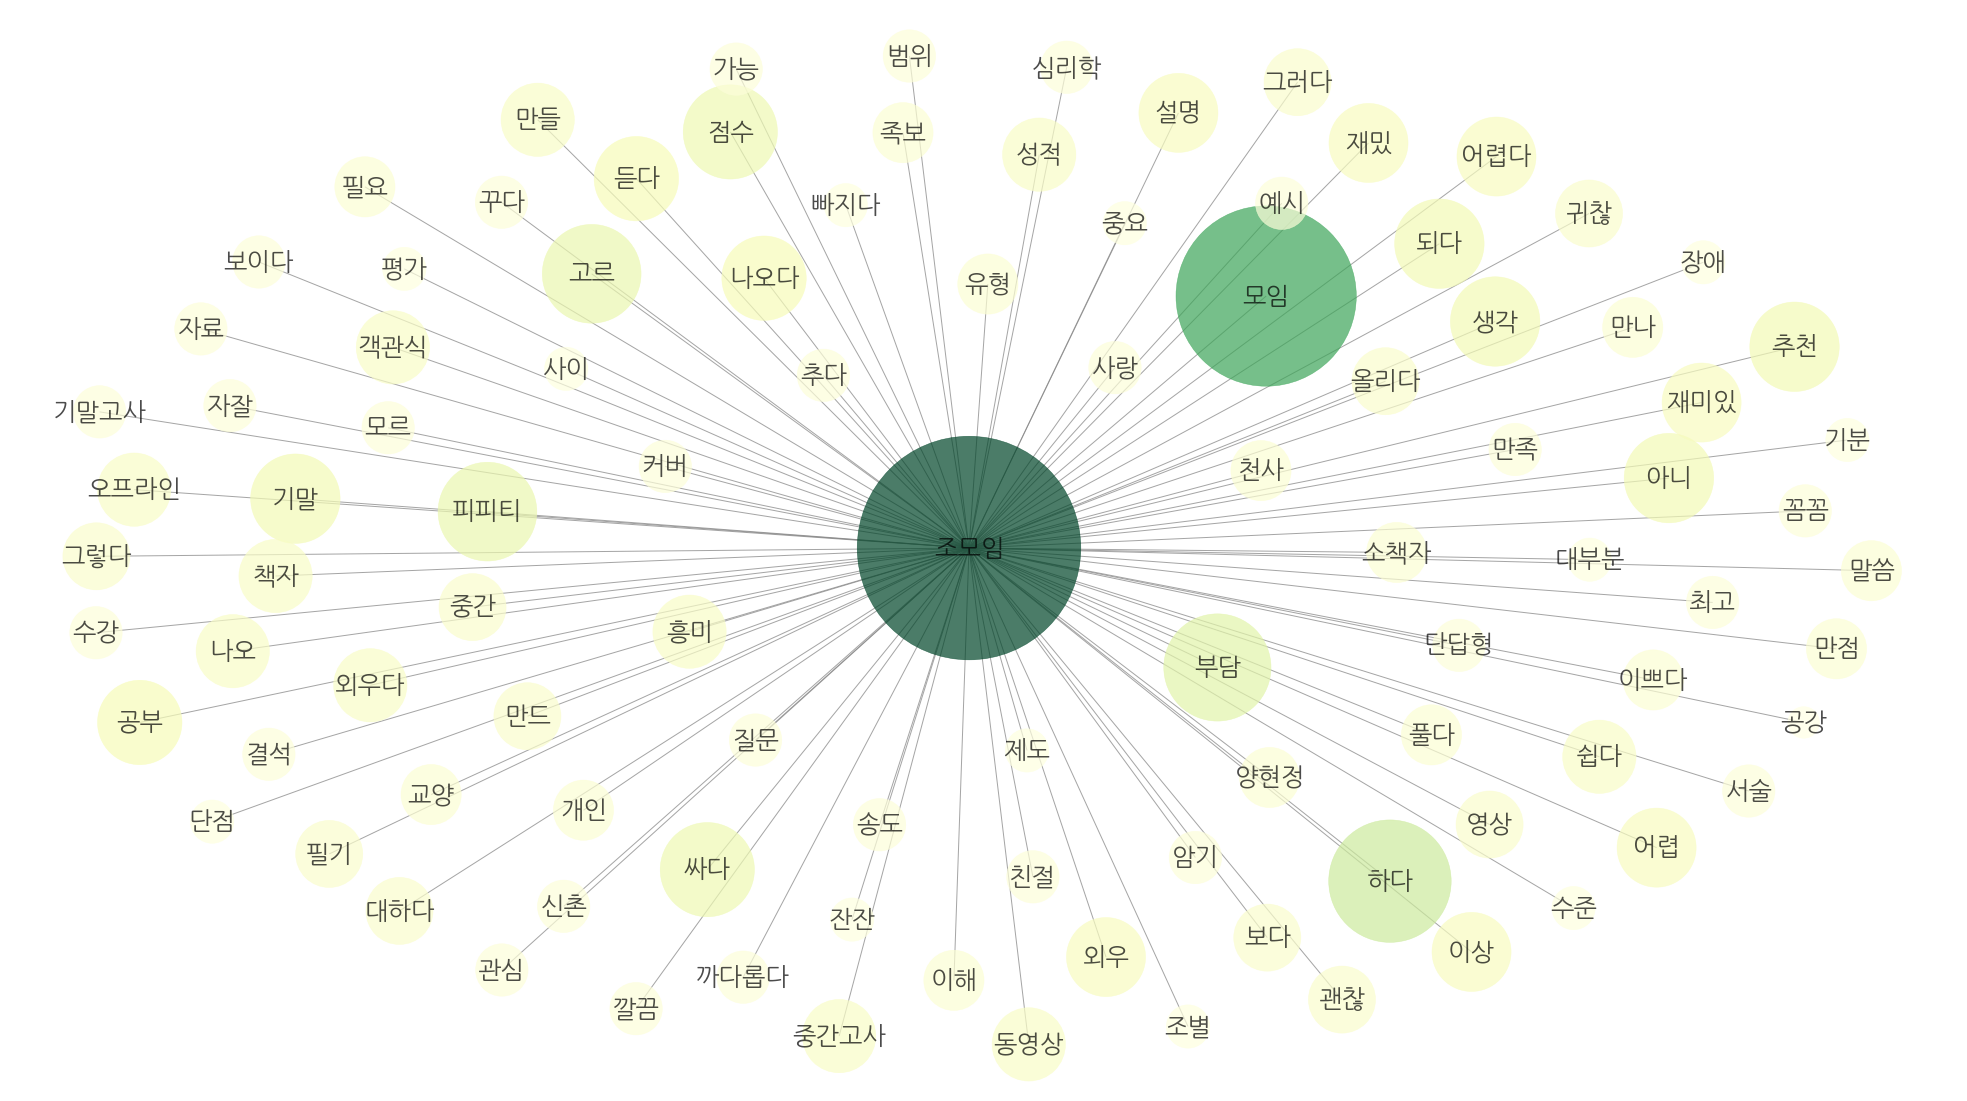

In [33]:
keyword_network('조모임', '이상행동의심리')

# keywords

# 평점 별 비율

In [12]:
lecture = '영화의이해'

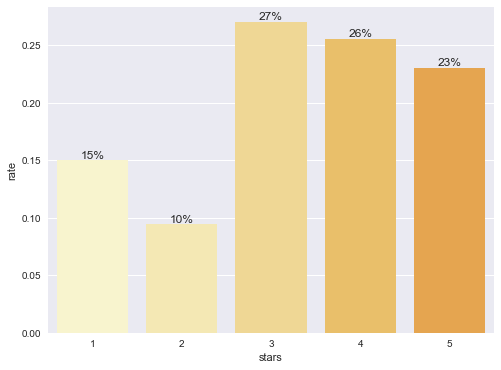

In [18]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import re

%matplotlib inline

# 한글폰트 지정
plt.rc("font", family = "Malgun Gothic")
plt.rc("axes", unicode_minus = False)


# 스타일 지정
plt.style.use(['seaborn'])


data_ = data[data['lecture'] == lecture]
stars = data_.groupby(['stars']).count()
stars['sum'] = stars['category'].sum()
stars['rate'] = stars['review']/stars['sum']

sns.set_palette("YlOrBr", 10)
plt.figure(figsize = (8,6))
g = sns.barplot(
    data = stars,
    x = stars.index,
    y = stars.rate)


for p in g.patches:
    left, bottom, width, height = p.get_bbox().bounds
    plt.annotate("%.f"%(height*100) + '%', (left+width/2, height*1.01), ha = 'center',fontsize = 12)
#plt.title(f'{lecture} : 평점 별 비율')
plt.show()

<AxesSubplot:xlabel='stars', ylabel='count'>

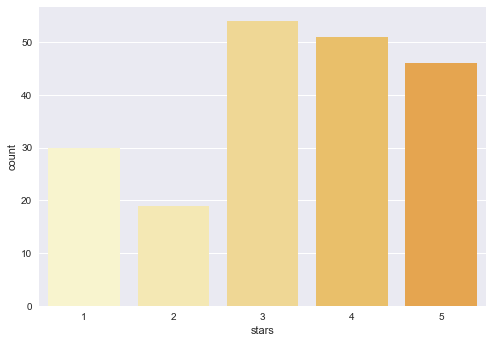

In [16]:
sns.countplot(x='stars',data=data_)